In [1]:
#purpose is to take HST images and identify extended sources (namely HH objects)

#just to check python version - should be 3.7.4
from platform import python_version
print(python_version())

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from reproject import reproject_exact  #a package that can be added to astropy using anaconda or pip (see their docs pg)
from reproject import reproject_interp

import glob
import itertools
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

3.8.5


In [2]:
# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #can edit this accordingly or edit your file names
    #using s.lower() includes uppercase extensions like FIT
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names

# #EX: grabbing all the fits image paths in a directory, #so they can be looped through and their data opened
# #set your path to some directory with images # (the images can be in subdirectories)
#the spitzer images
path = '../../n1333_photometry_ds9.bck.dir/**' # #using ** will grab all files even in subdirectories WARNING takes longer
im_names_spitz = im_name_finder(path, 'fit') #im_finder is basically glob.glob
im_names_spitz = [i.replace('\\', '/') for i in im_names_spitz]
im_names_spitz.remove('../../n1333_photometry_ds9.bck.dir/Frame20/n1333_band2_300_300_residual_hdrswap.fits')


#the hubble images
files_units = ['../../ngc1333_fits/126build_shift_2_drz.fits', 
                '../../ngc1333_fits/128build_shift_2_drz.fits', 
                '../../ngc1333_fits/164build_shift_2_drz.fits']

files_data = ['../../ngc1333_fits/126build_shift_2_drz.fits', 
                '../../ngc1333_fits/128build_shift_2_drz.fits', 
                '../../ngc1333_fits/164build_shift_2_drz.fits']

#initializing some lists to be used
hdu_pix_list = []
hdu_pixtorad_list = []
hdu_fnu_list = []
hdu_flam_list = []
hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []
# we ignore throughput since it is included (?) in the other conversion values I'm told
# throughput_list = [1., 1., 1., 1., 1., 1.] # [0.242, 1., 0.246, 0.496, 0.521, 0.470] #also has to be done by hand, not in the headers?

files_units = im_names_spitz + files_units
files_data = im_names_spitz + files_data

#opening data and headers
hdu_list_units = [fits.open(i) for i in files_units]
hdu_list = [fits.open(i) for i in files_data]

    
#I'm using count here just to point to specific indices that I've set up...unfortunately some have different headers...
#the only diff between the if and else cases are the indexing of the hdu's, some need 1 and some need 0
#I've tried to group it for convience, so the the first two have the same headers, the last 3 have the same headers
count = 0
for (hdu_units,hdu_data) in zip(hdu_list_units, hdu_list):
    if count < len(hdu_list)-3: #the spitzer ones
        #reading in conversions
        print(count, files_units[count])
        hdu_pix_list.append(hdu_units[0].header['CDELT2'])  #CDELT2 is the keyword for Spitzer images, in arcsec
        hdu_pixtorad_list.append(hdu_pix_list[count] * np.pi / 180.) #convert to radians
        # hdu_fnu_list.append(hdu_units[0].header['PHOTFNU'])
        # hdu_flam_list.append(hdu_units[0].header['PHOTFLAM'])
#         hdu_bw_list.append(hdu_units[0].header['PHOTBW'])

        #reading in datafor general use  and header for wcs
        #the spiter data is in MJy / sr, so let's convert out the MJy to Flam units, times by bw/calscale from earlier
        #this gets units of erg/cm^2/sec - we also times by 1 rad^2 - 1 sr!  
        hdu_data_list.append(hdu_data[0].data * 1e6 * 1e-23 * hdu_pixtorad_list[count]**2.)  
        hdu_header_list.append(hdu_data[0].header)
        
    else: #the hubble ones
        #reading in conversions
        hdu_pix_list.append(hdu_units[0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images, in sr
        hdu_pixtorad_list.append(hdu_pix_list[count] / 206265.)
        # hdu_fnu_list.append(hdu_units[0].header['PHOTFNU'])
        hdu_flam_list.append(hdu_units[0].header['PHOTFLAM'])
        hdu_bw_list.append(hdu_units[0].header['PHOTBW'])

        #reading in data for general use  and header for wcs
        #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
        hdu_data_list.append(hdu_data[1].data * hdu_units[0].header['PHOTFLAM'] * hdu_units[0].header['PHOTBW'])
        print(hdu_units[0].header['PHOTFLAM'], hdu_units[0].header['PHOTBW'])
        hdu_header_list.append(hdu_data[1].header)

    count += 1

print('loaded data!')

0 ../../n1333_photometry_ds9.bck.dir/Frame1/n1333_lh_3_FeII_flag400_2_map_fixed.FIT
1 ../../n1333_photometry_ds9.bck.dir/Frame10/n1333_sh_1_S32_map.fits
2 ../../n1333_photometry_ds9.bck.dir/Frame11/n1333_sh_NeII_2_map.fits
3 ../../n1333_photometry_ds9.bck.dir/Frame12/n1333_sh_S2_2_map.fits
4 ../../n1333_photometry_ds9.bck.dir/Frame13/n1333_sl1_NeII_bksub_trim_2_map.fits
5 ../../n1333_photometry_ds9.bck.dir/Frame14/n1333_sl1_S2_bksub_trim_2_map.fits
6 ../../n1333_photometry_ds9.bck.dir/Frame15/n1333_sl1_S3_bksub_trim_2_map_fixed1.FIT
7 ../../n1333_photometry_ds9.bck.dir/Frame16/n1333_sl1_S4_bksub_trim_3_map.fits
8 ../../n1333_photometry_ds9.bck.dir/Frame17/n1333_sl2_S5_bksub_trim_2_map.fits
9 ../../n1333_photometry_ds9.bck.dir/Frame18/n1333_sl2_S6_bksub_trim_3_map.fits
10 ../../n1333_photometry_ds9.bck.dir/Frame19/n1333_sl2_S7_bksub_trim_2_map.fits
11 ../../n1333_photometry_ds9.bck.dir/Frame2/n1333_lh_3_S0_flag400_2_map_fixed.FIT
12 ../../n1333_photometry_ds9.bck.dir/Frame3/n1333_lh_3_S

In [3]:
%matplotlib inline
hdu_list

[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x0000013273BD3FA0>],
 [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x0000013273ED2AC0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x00000132741F4220>, <astropy.io.fits.hdu.image.ImageHDU object at 0x0000013271A27460>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000001326DDB7550>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x000001326DDC2430>],
 [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x0000013273F977F0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x00000132742082E0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000001327360E250>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000001327360E430>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x000001327360E670>],
 [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x00000132740A3520>, <astropy.io.fits.hdu.image.ImageHDU object at 0x00000132742080A0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x0000013274214D30>, <astropy.io.fits.hdu.image.ImageHDU o

In [4]:
!conda install --yes --prefix {sys.prefix} -c conda-forge opencv

Solving environment: ...working... done

# All requested packages already installed.



-1

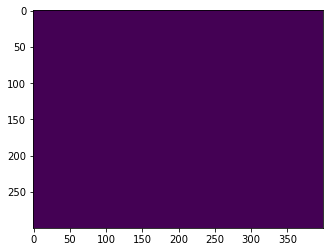

In [24]:
import cv2

#BASED ON https://stackoverflow.com/questions/61432335/blob-detection-in-python
'''
how to set a limit size for the blob? For example if the max blob size is smaller than some value, 
I want to be able to return "No Blob"

Add after big_contour=... blob_area = cv2.contourArea(big_contour) 
and then if blob_area < blob_area_thresh: print("Too Small") where blob_area_thresh is your area limitation.
'''

# do adaptive threshold on gray image
gray = hdu_data_list[-1][2700:3000, 4500:4900].astype(np.uint8) #picking only a portion of the image data
thresh = cv2.adaptiveThreshold(gray, 1e-16, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 3)

# apply morphology open then close
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
blob = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
blob = cv2.morphologyEx(blob, cv2.MORPH_CLOSE, kernel)

# invert blob
blob = (255 - blob)

# Get contours
cnts = cv2.findContours(blob, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
big_contour = max(cnts, key=cv2.contourArea)

# test blob size
blob_area_thresh = 1000
blob_area = cv2.contourArea(big_contour)
if blob_area < blob_area_thresh:
    print("Blob Is Too Small")

# draw contour
result = hdu_data_list[-1][2700:3000, 4500:4900].astype(np.uint8).copy()
cv2.drawContours(result, [big_contour], -1, (0,0,255), 1)

# write results to disk
# cv2.imwrite("doco3_threshold.jpg", thresh)
# cv2.imwrite("doco3_blob.jpg", blob)
# cv2.imwrite("doco3_contour.jpg", result)

# display it
# plt.imshow(hdu_data_list[-1][2700:3000, 4500:4900].astype(np.uint8)) # "IMAGE", 
# plt.imshow(thresh) # "THRESHOLD", 
# plt.imshow( blob) # "BLOB",
plt.imshow(result, vmin=0, vmax=1) #"RESULT", 
cv2.waitKey(0)

In [ ]:
#ALTERNATIVE METHOD with opencv2

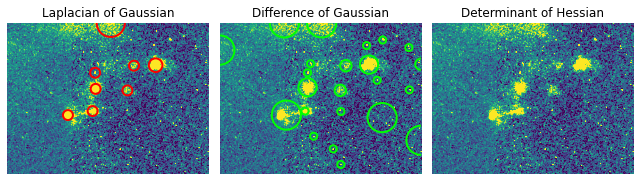

In [103]:
#first attempt skimage - using "blob methods" and circular apertures
#instead basically uses https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_blob.html
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

#the loop here is useless, but it does enable me to eventually slice the arrays and pick certain images
for image in hdu_data_list[-1:]:
    array_double = np.array(np.flip(image[2700:3000, 4500:4900], axis=0), dtype=np.double)
    
    blobs_log = blob_log(array_double, max_sigma=30, min_sigma=7, threshold=8e-18)

    # Compute radii in the 3rd column.
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

    blobs_dog = blob_dog(array_double, max_sigma=30, min_sigma=5, threshold=8e-18)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

    blobs_doh = blob_doh(array_double)
    blobs_doh[:, 2] = blobs_doh[:, 2] * sqrt(2)

    blobs_list = [blobs_log, blobs_dog, blobs_doh]
    colors =  ['red', 'lime', 'black']
    titles = ['Laplacian of Gaussian', 'Difference of Gaussian', 'Determinant of Hessian']
    sequence = zip(blobs_list, colors, titles)

    fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
    ax = axes.ravel()

    for idx, (blobs, color, title) in enumerate(sequence):
        ax[idx].set_title(title)
        ax[idx].imshow(array_double, vmin=-1e-18, vmax=3e-17)
        for blob in blobs:
            y, x, r = blob
            c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
            ax[idx].add_patch(c)
        ax[idx].set_axis_off()

    plt.tight_layout()

In [101]:
blobs_dog

array([[ 83.        , 296.        ,  18.1019336 ],
       [175.        , 169.        ,   7.07106781],
       [ 99.        , 174.        ,   7.07106781],
       [128.        , 174.        ,  18.1019336 ],
       [  0.        , 202.        ,  28.96309376],
       [183.        , 132.        ,  28.96309376],
       [  0.        , 128.        ,  28.96309376],
       [134.        , 239.        ,  11.3137085 ],
       [ 85.        , 250.        ,  11.3137085 ],
       [ 81.        , 180.        ,   7.07106781],
       [133.        , 376.        ,   7.07106781],
       [ 34.        , 323.        ,   7.07106781],
       [250.        , 225.        ,   7.07106781],
       [ 54.        ,   0.        ,  28.96309376],
       [ 45.        , 291.        ,   7.07106781],
       [281.        , 240.        ,   7.07106781],
       [225.        , 186.        ,   7.07106781],
       [233.        , 399.        ,  28.96309376],
       [ 82.        , 399.        ,  11.3137085 ],
       [ 49.        , 375.     

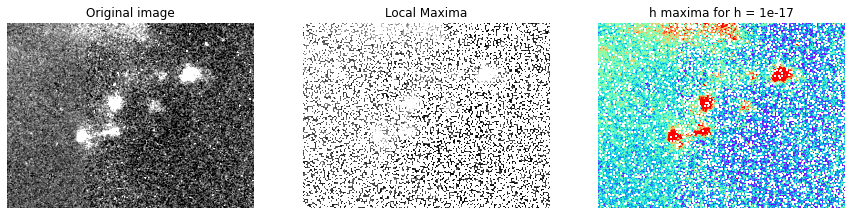

In [93]:
#next attempt is trying to use array_double with some other methods from skimage 
#https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_extrema.html#sphx-glr-auto-examples-segmentation-plot-extrema-py
#this example is about automatically finding local min/max
from skimage.measure import label
from skimage import color
from skimage.morphology import extrema
from skimage import exposure

# I quote: There is no a priori constraint on the density. (huh)

# We find all local maxima
local_maxima = extrema.local_maxima(array_double)
label_maxima = label(local_maxima)
overlay = color.label2rgb(label_maxima, array_double, alpha=0.7, bg_label=0,
                          bg_color=None, colors=[(1, 0, 0)])

# We observed in the previous image, that there are many local maxima
# that are caused by the noise in the image.
# For this, we find all local maxima with a height of h.
# This height is the gray level value by which we need to descent
# in order to reach a higher maximum and it can be seen as a local
# contrast measurement.
# The value of h scales with the dynamic range of the image, i.e.
# if we multiply the image with a constant, we need to multiply
# the value of h with the same constant in order to achieve the same result.
h = 1e-17
h_maxima = extrema.h_maxima(array_double, h)
label_h_maxima = label(h_maxima)
overlay_h = color.label2rgb(label_h_maxima, array_double, alpha=0.7, bg_label=0,
                            bg_color=None, colors=[(1, 0, 0)])

# a new figure with 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(array_double, cmap='gray', vmin=-1e-18, vmax=3e-17)
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(np.ma.masked_where(local_maxima, array_double), cmap='gray', vmin=-1e-18, vmax=3e-17)
# ax[1].imshow(overlay, vmin=-1e-18, vmax=3e-17)
ax[1].set_title('Local Maxima')
ax[1].axis('off')

ax[2].imshow(np.ma.masked_where(h_maxima, array_double), cmap='rainbow', vmin=-1e-18, vmax=3e-17)
#ax[2].imshow(overlay_h, vmin=-1e-18, vmax=3e-17)
ax[2].set_title('h maxima for h = ' + str(h))
ax[2].axis('off')
plt.show()

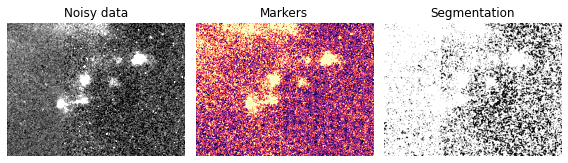

In [105]:
#now we try a lot of segmentation maps...
#follow https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_random_walker_segmentation.html#id2
from skimage.segmentation import random_walker
from skimage.data import binary_blobs
from skimage.exposure import rescale_intensity
import skimage

# The range of the binary image spans over (-1, 1).
# We choose the hottest and the coldest pixels as markers.
markers = np.zeros(array_double.shape, dtype=np.uint)
markers[array_double < 0] = 1
markers[array_double > 1e-17] = 2

# Run random walker algorithm
labels = random_walker(array_double, markers, beta=10, mode='bf')

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3.2),
                                    sharex=True, sharey=True)
ax1.imshow(array_double, cmap='gray', vmin=-1e-18, vmax=3e-17)
ax1.axis('off')
ax1.set_title('Noisy data')
ax2.imshow(markers, cmap='magma')
ax2.axis('off')
ax2.set_title('Markers')
ax3.imshow(labels, cmap='gray')
ax3.axis('off')
ax3.set_title('Segmentation')

fig.tight_layout()
plt.show()

In [ ]:
#for other options on skimage image segmentation
'''
https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_compact_watershed.html#sphx-glr-auto-examples-segmentation-plot-compact-watershed-py
https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html#sphx-glr-auto-examples-segmentation-plot-watershed-py
https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_expand_labels.html#sphx-glr-auto-examples-segmentation-plot-expand-labels-py
'''